## Access ANMN Aqualogger data in Parquet

A jupyter notebook to show how to access and plot ANMN Aqualogger data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "anmn_temperature_logger_ts_fv01"

In [2]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [3]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"
dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/parquet/loz_test/{dataset_name}/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

site_code: string
timestamp: int32
polygon: string


## List unique partition values

In [5]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'site_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['CH070', 'BMP070']
CPU times: user 28 ms, sys: 4.02 ms, total: 32 ms
Wall time: 30.9 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

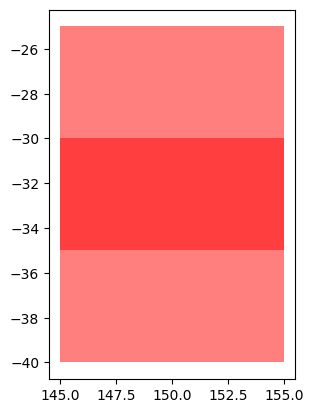

In [6]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2009, 7, 1, 10, 0), datetime.datetime(2024, 1, 1, 11, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [8]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'TIME': {'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': '0.0',
  'valid_max': '90000.0',
  'comment': 'timeOffsetPP: TIME values and time_coverage_start/end global attributes have been applied the following offset : -10 hours.'},
 'TIMESERIES': {'long_name': 'unique_identifier_for_each_timeseries_feature_instance_in_this_file',
  'cf_role': 'timeseries_id'},
 'LATITUDE': {'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'reference_datum': 'WGS84 coordinate reference system',
  'valid_min': '-90.0',
  'valid_max': '90.0'},
 'LONGITUDE': {'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'reference_datum': 'WGS84 coordinate reference system',
  'valid_min': '-180.0',
  'valid_max': '180.0'},
 'NOMINAL_DEPTH': {'standard_name': 'depth',
  'long_name': 'nominal depth',
  'units': 'm',
  'axis': 'Z',
  'positive': 'down',
  'reference_datum': 'sea surface',

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [9]:
filter_time = create_time_filter(parquet_ds, date_start='2022-12-02', date_end='2022-12-26')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)


filter = filter_geo & filter_time

In [10]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow', filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110558 entries, 0 to 110557
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   TIME                   110558 non-null  datetime64[ns]
 1   TIMESERIES             110558 non-null  int32         
 2   LATITUDE               110558 non-null  float64       
 3   LONGITUDE              110558 non-null  float64       
 4   NOMINAL_DEPTH          110558 non-null  float32       
 5   TEMP                   110558 non-null  float32       
 6   TEMP_quality_control   110558 non-null  float32       
 7   PRES                   89809 non-null   float32       
 8   PRES_quality_control   89809 non-null   float32       
 9   DEPTH                  110553 non-null  float32       
 10  DEPTH_quality_control  110558 non-null  float32       
 11  filename               110558 non-null  object        
 12  site_code              110558 non-null  cate

## Create a TIME and scalar/number filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2022-12-02', date_end='2022-12-26')

expr_1 = pc.field('site_code') == pa.scalar("BMP070")
filter = expr_1 & filter_time
filter

<pyarrow.compute.Expression ((site_code == "BMP070") and ((((timestamp >= 1664582400) and (timestamp <= 1664582400)) and (TIME >= 2022-12-02 00:00:00.000000)) and (TIME <= 2022-12-26 00:00:00.000000)))>

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62217 entries, 0 to 62216
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   TIME                   62217 non-null  datetime64[ns]
 1   TIMESERIES             62217 non-null  int32         
 2   LATITUDE               62217 non-null  float64       
 3   LONGITUDE              62217 non-null  float64       
 4   NOMINAL_DEPTH          62217 non-null  float32       
 5   TEMP                   62217 non-null  float32       
 6   TEMP_quality_control   62217 non-null  float32       
 7   PRES                   41478 non-null  float32       
 8   PRES_quality_control   41478 non-null  float32       
 9   DEPTH                  62217 non-null  float32       
 10  DEPTH_quality_control  62217 non-null  float32       
 11  filename               62217 non-null  object        
 12  site_code              62217 non-null  category      
 13  t

In [13]:
df['NOMINAL_DEPTH'].unique()

array([71.9, 13. , 20. , 36. , 60. , 68. , 28. , 44. , 52. ],
      dtype=float32)

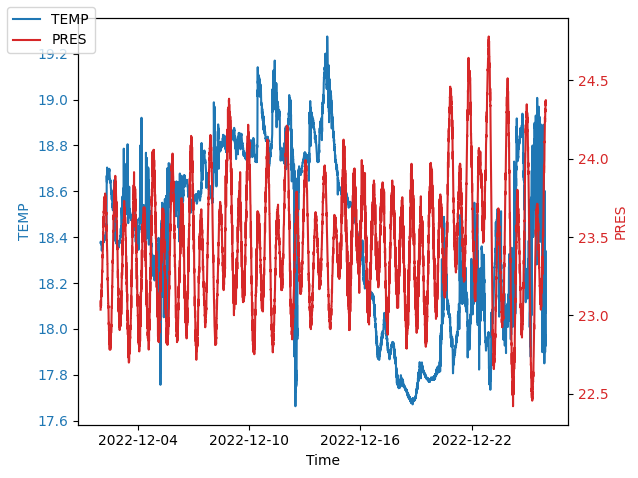

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame where NOMINAL_DEPTH == 20
filtered_df = df[df['NOMINAL_DEPTH'] == 13]

# Plotting
fig, ax1 = plt.subplots()

# Plot TEMP on the primary y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('TEMP', color=color)
ax1.plot(filtered_df['TIME'], filtered_df['TEMP'], color=color, label='TEMP')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for PRES
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PRES', color=color)
ax2.plot(filtered_df['TIME'], filtered_df['PRES'], color=color, label='PRES')
ax2.tick_params(axis='y', labelcolor=color)

# Set a fixed number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number of ticks as needed

# Show legend
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()